In [2]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, datasets
import pandas as pd
from tqdm import tqdm

import spacy
import numpy as np

import random
import math
import time

from seq2seq import utils, helpers
import re
import os
import pickle

# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

**Set constants**

In [3]:
DATASET_PATH = f"../.data/miguel"
SRC_LANG = "en"
TRG_LANG = "es"
SOS_WORD = '<sos>'
EOS_WORD = '<eos>'

## Load dataset

To speed things up, I prefer to use torchtext directly in order to read the CSV files, preprocess
them and tokenize each pair.

I'm gonna use the tokenizer from Spacy, which is a Natural Language Processing library that is blazingly fast, suitable
for large datasets, with support for many language and hundreds of features.

This step can take a while but since I plan to save our tokenized datasets, it  won't be a problem.

Also note that I'm converting everything to lowercase, and adding the `<sos>` and `<eos>` tokens to our pairs.


In [4]:
SRC = data.Field(tokenize='spacy', tokenizer_language=SRC_LANG, init_token=SOS_WORD, eos_token=EOS_WORD, lower=True)
TRG = data.Field(tokenize='spacy', tokenizer_language=TRG_LANG, init_token=SOS_WORD, eos_token=EOS_WORD, lower=True)

/home/salvacarrion/.local/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [5]:
data_fields = [('src', SRC), ('trg', TRG)]
train_data, dev_data, test_data = data.TabularDataset.splits(path=f'{DATASET_PATH}/preprocessed/',
                                                             train='test.csv', validation='dev.csv', test='test.csv',
                                                             format='csv', fields=data_fields, skip_header=True)

/home/salvacarrion/.local/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/home/salvacarrion/.local/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


## Dataset exploration

On the first part of the exploration we perform some sanity checks to make sure that our preprocessed dataset are valid.

Print the number of pairs for each partition: train, dev and test.

In [6]:
print("Total pairs:")
print(f"\t- Train: {len(train_data.examples)}")
print(f"\t- Dev: {len(dev_data.examples)}")
print(f"\t- Test: {len(test_data.examples)}")

Total pairs:
	- Train: 3003
	- Dev: 3003
	- Test: 3003


### Viewing tokens

Now, we can the print the tokenized pairs to see what are we really doing. I usually like to print the first and last
`n` pairs (and a few random ones).


----
**Old:**
*Below we see a few things. First, the tokenization looks good. Nevertheless, we see that there are still a few
things that can be annoying such as `\xa0` or `"`. Maybe I should normalize the strings to avoid those problems.*

In [7]:
def view_pairs(pairs, indices):
    for i, idx in enumerate(indices):
        (src, trg) = pairs[idx].src, pairs[idx].trg
        print(f"#{i+1}: " + "-"*20)
        print(f"src => {src}")
        print(f"trg => {trg}")
    print("")

In [8]:
n=10
print("Head: " + "#"*20)
print("(Firsts) Train dataset: " + "*"*20)
view_pairs(train_data.examples, indices=range(0, n))

print("(Firsts) Dev dataset: " + "*"*20)
view_pairs(dev_data.examples, indices=range(0, n))

print("(Firsts) Test dataset: " + "*"*20)
view_pairs(test_data.examples, indices=range(0, n))

print("Tail: " + "#"*20)
print("(Lasts) Train dataset: " + "*"*20)
view_pairs(train_data.examples, indices=range(-1,-n-1,-1))

print("(Lasts) Dev dataset: " + "*"*20)
view_pairs(dev_data.examples, indices=range(-1,-n-1,-1))

print("(Lasts) Test dataset: " + "*"*20)
view_pairs(test_data.examples, indices=range(-1,-n-1,-1))


Head: ####################
(Firsts) Train dataset: ********************
#1: --------------------
src => ['parliament', 'does', 'not', 'support', 'amendment', 'freeing', 'tymoshenko']
trg => ['el', 'parlamento', 'no', 'apoyó', 'una', 'enmienda', 'para', 'liberar', 'a', 'tymoshenko']
#2: --------------------
src => ['today', ',', 'the', 'ukraine', 'parliament', 'dismissed', ',', 'within', 'the', 'code', 'of', 'criminal', 'procedure', 'amendment', ',', 'the', 'motion', 'to', 'revoke', 'an', 'article', 'based', 'on', 'which', 'the', 'opposition', 'leader', ',', 'yulia', 'tymoshenko', ',', 'was', 'sentenced', '.']
trg => ['el', 'parlamento', 'de', 'ucrania', '\xa0', 'ha', 'rechazado', 'hoy', '\xa0', 'la', '\xa0', 'propuesta', 'de', 'derogar', 'la', 'enmienda', 'de', 'la', '\xa0', 'sección', 'del', 'código', '\xa0', 'penal', '\xa0', 'en', 'la', 'que', 'se', '\xa0', 'condena', 'a', 'la', '\xa0', 'líder', 'de', 'la', 'oposición', '\xa0', 'yulia', '\xa0', 'tymoshenko', '.']
#3: ----------------

### Sequence lengths

Since some of models that use of attention have a quadratic growth with regard the length of a sequence, we need to 
carefully study the lengths of the pairs in our dataset so that we can choose the maximum length of a sequence in a 
educated way.

From the results below we observe a huge gap between pairs. This gap gets accentuated for the train and dev/test partitions. In the former, the gap is greater than in the later.

In [9]:
# Get lengths
train_lenghts = np.array([(len(pair.src), len(pair.trg)) for pair in train_data.examples])
dev_lenghts = np.array([(len(pair.src), len(pair.trg)) for pair in dev_data.examples])
test_lenghts = np.array([(len(pair.src), len(pair.trg)) for pair in test_data.examples])

# Get min lengths
train_min_len = train_lenghts.min(axis=0).astype(int)
dev_min_len = dev_lenghts.min(axis=0).astype(int)
test_min_len = test_lenghts.min(axis=0).astype(int)


# Get max lengths
train_max_len = train_lenghts.max(axis=0).astype(int)
dev_max_len = dev_lenghts.max(axis=0).astype(int)
test_max_len = test_lenghts.max(axis=0).astype(int)

In [10]:
print(f"Train => Range length: src={train_min_len[0]}-{train_max_len[0]} | trg={train_min_len[1]}-{train_max_len[1]}")
print(f"Dev => Range length: src={dev_min_len[0]}-{dev_max_len[0]} | trg={dev_min_len[1]}-{dev_max_len[1]}")
print(f"Test => Range length: src={test_min_len[0]}-{test_max_len[0]} | trg={test_min_len[1]}-{test_max_len[1]}")

Train => Range length: src=1-137 | trg=1-140
Dev => Range length: src=1-137 | trg=1-140
Test => Range length: src=1-137 | trg=1-140


#### Checking for zero-length sequences

Additionally, I like to check if there is any sequence with length zero. This is more important that it looks, since an empty sequence could indicate an error or problem in the dataset which could lead to a waste of computational resources, a `RuntimeError` in the middle of the training or even jeopardising the training of our model

In [11]:
tr_no_sent = np.sum(train_lenghts == 0, axis=0).astype(int)
dev_no_sent = np.sum(dev_lenghts == 0, axis=0).astype(int)
ts_no_sent = np.sum(test_lenghts == 0, axis=0).astype(int)

print(f"Train => Sentences with no words: SRC={tr_no_sent[0]} | TRG={tr_no_sent[1]}")
print(f"Dev => Sentences with no words: SRC={dev_no_sent[0]} | TRG={dev_no_sent[1]}")
print(f"Test => Sentences with no words: SRC={ts_no_sent[0]} | TRG={ts_no_sent[1]}")

Train => Sentences with no words: SRC=0 | TRG=0
Dev => Sentences with no words: SRC=0 | TRG=0
Test => Sentences with no words: SRC=0 | TRG=0


### Viewing extreme sequences

To know the range in which the sequences are ranging is important, but it is even more important to understand what are the extreme pairs in that range. By studying these extreme cases, we can educatively tune our model to get the most of our dataset without compromissing their requirements too much.

To get these extreme pairs, we simply keep the indices of the sorted lengths using `argsort`.

In [12]:
def view_lengths(raw, indices):
    for i, idx in enumerate(indices):
        p1_src, p1_trg = raw[idx[0]].src, raw[idx[0]].trg  # Shortest src (+trg)
        p2_src, p2_trg = raw[idx[1]].src, raw[idx[1]].trg  # Shortest trg (+src)

        
        print(f"#{i+1}: " + "-"*20)
        print(f"[Shortest SRC: idx={idx[0]}]")
        print(f"\t- src (len={len(p1_src)}): {p1_src} => {p1_trg}")
        
        print(f"[Shortest TRG: idx={idx[1]}]")
        print(f"\t- trg (len={len(p2_src)}): {p2_src} => {p2_trg}")
    print("")

In [13]:
# Sort columns independently (ascending)
train_sort_len_idx = np.argsort(train_lenghts, axis=0)
dev_sort_len_idx = np.argsort(dev_lenghts, axis=0)
test_sort_len_idx = np.argsort(test_lenghts, axis=0)

Now we see which sentences contain the minimum and the maximum number of tokens. The shortests sequences correspond to word-to-word translations such as: `italy => italia` or `Informality => Informalidad`.
 
**Notice** that columns in the array are sorted independely. This is because a source sequence can be a single word but its translation can be many (and viceversa), such as: `shopping => ir de compras`

In [14]:
n=5
print("Shortest: " + "#"*20)
print("(Shortest) Train dataset: " + "*"*20)
view_lengths(train_data.examples, indices=train_sort_len_idx[:n])

print("(Shortest) Dev dataset: " + "*"*20)
view_lengths(dev_data.examples, indices=dev_sort_len_idx[:n])

print("(Shortest) Test dataset: " + "*"*20)
view_lengths(test_data.examples, indices=test_sort_len_idx[:n])

print("Longest: " + "#"*20)
print("(Longest) Train dataset: " + "*"*20)
view_lengths(train_data.examples, indices=train_sort_len_idx[::-1][:n])

print("(Longest) Dev dataset: " + "*"*20)
view_lengths(dev_data.examples, indices=dev_sort_len_idx[::-1][:n])

print("(Longest) Test dataset: " + "*"*20)
view_lengths(test_data.examples, indices=test_sort_len_idx[::-1][:n])



Shortest: ####################
(Shortest) Train dataset: ********************
#1: --------------------
[Shortest SRC: idx=2573]
	- src (len=1): ['italy'] => ['italia']
[Shortest TRG: idx=2573]
	- trg (len=1): ['italy'] => ['italia']
#2: --------------------
[Shortest SRC: idx=437]
	- src (len=1): ['gossiping'] => ['calumnias', 'y', 'chismes']
[Shortest TRG: idx=2621]
	- trg (len=1): ['austria'] => ['austria']
#3: --------------------
[Shortest SRC: idx=1873]
	- src (len=1): ['informality'] => ['informalidad']
[Shortest TRG: idx=1882]
	- trg (len=1): ['reactions'] => ['reacciones']
#4: --------------------
[Shortest SRC: idx=2621]
	- src (len=1): ['austria'] => ['austria']
[Shortest TRG: idx=179]
	- trg (len=1): ['review'] => ['reseña']
#5: --------------------
[Shortest SRC: idx=1880]
	- src (len=1): ['debt'] => ['la', 'deuda']
[Shortest TRG: idx=1873]
	- trg (len=1): ['informality'] => ['informalidad']

(Shortest) Dev dataset: ********************
#1: --------------------
[Shortest SR

### Plotting length distribution

After printing a few examples of pairs, it is interesting to plot the length distribution of the different partitions so we can get an intuition on where to set the length cut.

From the plots below, we see that the train partition come from a different source than our dev and test partitions. Luckily, this won't be a problem for setting out cut since the training partition is way bigger than our dev/test partitions

In [15]:
# Get lengths
tr_src_len = train_lenghts[:, 0]
tr_trg_len = train_lenghts[:, 1]
dev_src_len = dev_lenghts[:, 0]
dev_trg_len = dev_lenghts[:, 1]
ts_src_len = test_lenghts[:, 0]
ts_trg_len = test_lenghts[:, 1]

# Pair data and labels
h_data = [tr_src_len, tr_trg_len, dev_src_len, dev_trg_len, ts_src_len, ts_trg_len]
h_labels = ['tr_src_len', 'tr_trg_len', 'dev_src_len', 'dev_trg_len', 'ts_src_len', 'ts_trg_len']

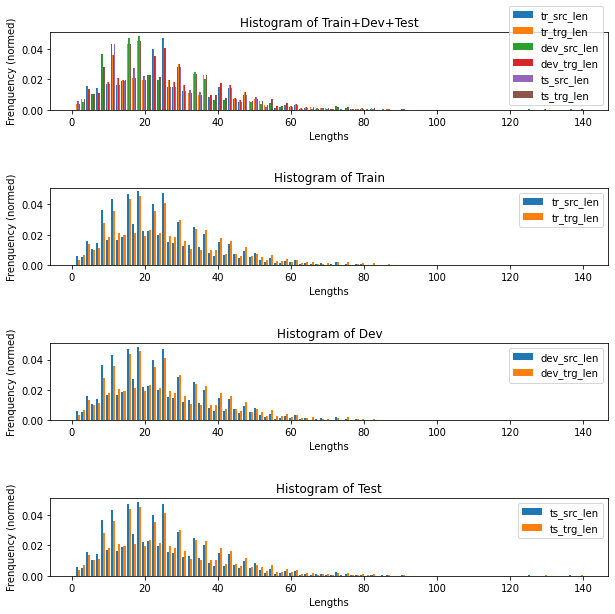

In [16]:
def get_hist(ax, data, labels, title, bins=100):
    # Draw the plot
    ax.hist(data, bins=bins, density=True, label=labels)

    # Title and labels
    ax.set_title(title)
    ax.set_xlabel("Lengths")
    ax.set_ylabel("Frenquency (normed)")
    ax.legend()


plt.rcParams['figure.figsize'] = [10, 10]

fig, axs = plt.subplots(4)
get_hist(axs[0], h_data, h_labels, f"Histogram of Train+Dev+Test")
get_hist(axs[1], h_data[0:2], h_labels[0:2], f"Histogram of Train")
get_hist(axs[2], h_data[2:4], h_labels[2:4], f"Histogram of Dev")
get_hist(axs[3], h_data[4:6], h_labels[4:6], f"Histogram of Test")

plt.rcParams['figure.figsize'] = [10, 10]
plt.subplots_adjust(hspace=1.0)

### Sequence length stats

We can also get some statistical values from partitions to get a rough idea of how long is the average sequence or in which range of values we can find 95% of our data.

By doing this, we are obtaining a value with which perform the sequence cut in the dataset.

In [17]:
# Get means
train_mean_len = train_lenghts.mean(axis=0).round().astype(int)
dev_mean_len = dev_lenghts.mean(axis=0).round().astype(int)
test_mean_len = test_lenghts.mean(axis=0).round().astype(int)

print(f"Train => Mean length: src={train_mean_len[0]} | trg={train_mean_len[1]}")
print(f"Dev => Mean length: src={dev_mean_len[0]} | trg={dev_mean_len[1]}")
print(f"Test => Mean length: src={test_mean_len[0]} | trg={test_mean_len[1]}")

Train => Mean length: src=25 | trg=26
Dev => Mean length: src=25 | trg=26
Test => Mean length: src=25 | trg=26


### Setting the length threshold

Let's say that our model has only memory for sequences with a maximum of 150 tokens. With this value in mind (and the sequence length distribution), we can now exactly know how much data we are leaving behind. 

This is important so that we can get the most of our model by carefully tuning it with the statistical values that we have calculated. Additionally, since this is an educated process, we will also have a rough idea of how much our model could improve if we increase the computational resources.

In [18]:

def get_percentiles(src_trg_lengths, lower_q, upper_q):
    p = np.percentile(src_trg_lengths,  [lower_q, upper_q], axis=0)
    (lb_tr_src_len, lb_tr_trg_len), (ub_tr_src_len, ub_tr_trg_len) = p

    print(f"- SRC ({lower_q}-{upper_q}%): {int(lb_tr_src_len)}-{int(ub_tr_src_len)}")
    print(f"- TRG ({lower_q}-{upper_q}%): {int(lb_tr_trg_len)}-{int(ub_tr_trg_len)}")

    return p

lower_q, upper_q = (0, 99.65)  # Percentage
print("Percentile Train:")
tr_p = get_percentiles(train_lenghts, *(lower_q, upper_q))
print("Percentile Dev:")
dev_p = get_percentiles(dev_lenghts, *(lower_q, upper_q))
print("Percentile Test:")
ts_p = get_percentiles(test_lenghts, *(lower_q, upper_q))

Percentile Train:
- SRC (0-99.65%): 1-77
- TRG (0-99.65%): 1-80
Percentile Dev:
- SRC (0-99.65%): 1-77
- TRG (0-99.65%): 1-80
Percentile Test:
- SRC (0-99.65%): 1-77
- TRG (0-99.65%): 1-80


### Vocabulary

For the next step we will build the vocabulary. That is, creating a list of unique words/tokens that our model will
"understand". All the other words that are not in the vocabulary will be marked as `<unk>`.

Technically, we cannot use the dev partition for anything but evaluating our model during training. We do this in
order to avoid overfitting our model on the "super secret" test partition. Hance, we have to build the vocabulary
using only the train partition.

In [26]:
# Define Train fields
train_src = data.Field(tokenize='spacy', tokenizer_language=SRC_LANG, init_token=SOS_WORD, eos_token=EOS_WORD, lower=True)
train_trg = data.Field(tokenize='spacy', tokenizer_language=TRG_LANG, init_token=SOS_WORD, eos_token=EOS_WORD, lower=True)

# Build vocabulary
train_src.build_vocab(train_data.src)
train_trg.build_vocab(train_data.trg)

Train vocab:
=> SRC (most common): [('the', 5118), (',', 3615), ('.', 2803), ('of', 2387), ('to', 1714), ('in', 1568), ('a', 1498), ('and', 1478), ('"', 1378), ('that', 833)]
=> SRC (least common): [('enthusiastic', 1), ('lucid', 1), ('42', 1), ('queiroz', 1), ('obliges', 1), ('carries', 1), ('regrets', 1), ('possessing', 1), ('exert', 1), ('maximal', 1), ('prove', 1)]
=> TRG (most common): [('de', 4726), (',', 4183), ('la', 2801), ('.', 2753), ('el', 2402), ('en', 2153), ('que', 1950), ('"', 1498), ('y', 1456), ('a', 1428)]
=> TRG (least common): [('entusiasmado', 1), ('dixit', 1), ('lúcido', 1), ('42', 1), ('relativizado', 1), ('queiroz', 1), ('obliga', 1), ('lamenta', 1), ('intención', 1), ('máxima', 1), ('dejarles', 1)]


#### Vocabulary size

Once the vocabulary is built, we need to check its size and see if we need to perform some refinement.

Anything between 10k to 15k seems reasonable. We could go for even 30k for big models.

In [27]:
print(f"Words in SRC vocabulary: {len(train_src.vocab.freqs)}")
print(f"Words in TRG vocabulary: {len(train_trg.vocab.freqs)}")

Words in SRC vocabulary: 9401
Words in TRG vocabulary: 11829


#### Vocabulary refinement

We can use all unique tokens found in the train partition as our "vocabulary", but this is usually not a good idea since
many of the less frequent words in the vocabulary will be typos, personal names, words in another languages, etc.
Moreover, using everything as our vocabulary would notable increase the resources needed.

Luckily, there is a really simple solution to deal with this problem: Using the `k` most frequent words.

From the words below, we see that everything is reasonable as since the vocabulary is not that big, we could leave
it as is.

In [30]:
n=50

print("Train vocab:")
print("=> SRC (most common): " + str(train_src.vocab.freqs.most_common(n)))
print("=> SRC (least common): " + str(train_src.vocab.freqs.most_common()[-n-1:]))
print("=> TRG (most common): " + str(train_trg.vocab.freqs.most_common(n)))
print("=> TRG (least common): " + str(train_trg.vocab.freqs.most_common()[-n-1:]))

Train vocab:
=> SRC (most common): [('the', 5118), (',', 3615), ('.', 2803), ('of', 2387), ('to', 1714), ('in', 1568), ('a', 1498), ('and', 1478), ('"', 1378), ('that', 833), ('is', 761), ('for', 599), ('on', 549), ('-', 502), ('it', 486), ('was', 435), ('with', 423), ('by', 381), ('he', 374), ('not', 372), ('at', 331), ('be', 326), ("'s", 321), ('as', 319), ('are', 307), ('from', 296), ('this', 277), ('has', 262), ('an', 250), ('have', 236), ('his', 225), ('will', 221), ('said', 221), ('which', 204), ('but', 202), ('we', 186), ('would', 185), ('i', 182), ('one', 178), ('were', 174), (')', 172), ('who', 172), ('or', 171), ('(', 171), ('you', 170), ('its', 164), ('there', 163), ('they', 160), ('had', 156), ('their', 154)]
=> SRC (least common): [('attacker', 1), ('selector', 1), ('assures', 1), ('lillois', 1), ('performances', 1), ('justified', 1), ('lille', 1), ('marks', 1), ('denis', 1), ('pleasing', 1), ('encouraged', 1), ('victorious', 1), ('necessarily', 1), ('participates', 1), ('

## Saving preprocessed dataset

Since preprocessing and tokenizing a big dataset can take time, I recommend to save it always, if possible, in other
to save us some time when debugging our model.

For torchtext, we'll need to save the preprocessed examples for the train, dev and test partitions, along with their
fields. Depending on the case we can ignore the last part. Here, I'll save only the train fields with their
vocabularies.